# 포유강(쥐목, 식육목, 캥거루목) COI 염기서열 추출 후 군집화(Alignment 과정 x + 비지도학습)

## 데이터 수집 자동 크롤러를 위한 함수들(getOrganism() -> getGenbank())

In [1]:
#[220505_1137]UPDATED 지금까지 구성을 전부 정리함
from Bio import Entrez, SeqIO, AlignIO
from Bio.Align.Applications import MuscleCommandline
from pathlib import Path
from Bio import GenBank
from Bio.SeqUtils import GC

Entrez.email = "nagabuti13@naver.com"

#[220502_1717]CREATED getIdList: NCBI에서 keyword를 검색하여 script의 id를 추출한다
#[220512_1210]NOTED esearch()의 파라미터에 id의 개수를 조절하는 retmax 파라미터가 존재
def getIdlist(database, keyword):
    handle = Entrez.esearch(db = database, retmax = 10000, term = keyword)
    records = Entrez.read(handle)
    return records["IdList"]

#[220505_1717]CREATED getFastaFile: NCBI에서 id를 검색하여 얻은 fasta파일을 컴퓨터에 저장한다
def getFasta(id):
    handle = Entrez.efetch(db = 'nucleotide', id = id, rettype = 'fasta', retmode = 'text')
    record = SeqIO.read(handle, 'fasta')
    print('## creating ' + record.id + '.fasta...')
    with open(record.id + '.fasta', 'w') as f:
        f.write('>' + record.description + '\n')
        f.write(str(record.seq) + '\n')
    
#[220502_1717]CREATED getAlnFile: 다중염기서열을 생성하는 툴 중 하나인 MUSCLE로 aln파일을 생성한다
def getAln(filename):
    muscle_exe = '/Users/kimjoonsu/muscle3.8.31_i86darwin64'
    cmd_line = MuscleCommandline(muscle_exe, input = filename,
                             out = Path(filename).stem + '.aln', clw = ' ')
    print(cmd_line)
    stdout, stderr = cmd_line()   
    
#[220509_1517]CREATED ncbi에서 alignment의 각 record genbank파일로부터 종 이름을 반환
def getGenbank(id):
    handle = Entrez.efetch(db = "nucleotide", rettype = "gb", id = id, retmode = "text")
    r = GenBank.read(handle)
    #[220811_1431]NOTED getOrganism() -> getGenbank()
    return r

## k_gc값 변화에 따른 데이터 분포 시각화

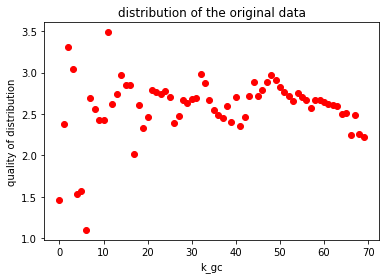

In [5]:
def setGC(filename, index):
    import pandas as pd
    import numpy as np

    file = SeqIO.parse(filename, 'fasta')

    l = []
    for record in file:
        l.append(len(record.seq))
    k_gc = min(l)
    k_gc += index
    #print(k_gc)
    return k_gc
    #[220805_1705]NOTED 길이가 가장 짧은 시퀀스의 bp를 k-mers의 k로 설정

def creMaxGCDf(filename, k_gc):
    import pandas as pd
    import numpy as np
    
    gc_df = pd.DataFrame()
    gc_df['start index'] = 0
    gc_df['gc-contents'] = 0

    file = SeqIO.parse(filename, 'fasta')

    for i, record in enumerate(file):
        index = 0
        gc_rates = []
        while(index + k_gc <= len(record.seq)):
            mer = record.seq[index:index + k_gc]
            gc_rates.append(GC(mer))
            index += 1
        if(index == 0):
            gc_rates.append(GC(record.seq))
        gc_df.loc[i, 'start index'] = gc_rates.index(max(gc_rates))
        #[220805_1706]NOTED GC함량이 가장 높은 mer의 시작 인덱스를 저장
        gc_df.loc[i, 'gc-contents'] = max(gc_rates)
        #[220805_1706]NOTED GC함량이 가장 높은 mer의 GC함량을 저장
    return gc_df

def creDf(filename, gc_df, k_gc):
    import pandas as pd
    import numpy as np

    file = SeqIO.parse(filename, 'fasta')

    k = 3
    dict = {}
    df = pd.DataFrame()

    #[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
    base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
    'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

    #[220508_1735]CREATED k = 3인 kmer의 모든 경우의 수를 사전형에 미리 저장
    def init(datatype):
        for i in range(4):
            for j in range(4):
                for k in range(4):
                    datatype[list(base_dict.keys())[i] + list(base_dict.keys())[j] + list(base_dict.keys())[k]] = 0
        #[220509_1517]CREATED k-means는 unsupervised이지만, 여기서는 표본의 타겟을 ncbi에서부터 추출가능하므로 타겟 피처 생성
        datatype['GC-contents'] = 0
        datatype['target'] = 0
        
    init(df)

    for i, record in enumerate(file):
        init(dict)
        record.seq = record.seq[int(gc_df.loc[i, 'start index']): int(gc_df.loc[i, 'start index']) + k_gc]
        #[220805_1023]CREATED 최대 GC 값 범위로 기존 데이터 슬라이싱
        dict['GC-contents'] = gc_df.loc[i, 'gc-contents']
        #[220805_1025]CREATED 최대 GC 값 저장
        dict['target'] = getGenbank(record.id).organism
        
        index = 0
        
        if(len(record.seq) >= k):
            while(index + k <= len(record.seq)):
                mer = record.seq[index:index + k]
                for p in range(k):
                    mer = mer.replace(mer[p], base_dict.get(mer[p]))
                dict[mer] += 1
                index += 1
        df.loc[i] = dict
    return df

def calSilhouette(df):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score
    import numpy as np

    df['sil_sam'] = silhouette_samples(df.loc[:,'AAA':'GC-contents'], df['target'])
    #[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
    sil_tot = silhouette_score(df.loc[:,'AAA':'GC-contents'], df['target'])
    #[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
    sil_clu = df.groupby('target')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    #print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    #print('score: {0:.3f}'.format(score_k))
    #[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
    #print('---------------')
    return sil_tot / score_k



import matplotlib.pyplot as plt
import numpy as np

index = 0
filename = 'all_mammalia_coi.fasta'

sil_ratios = []

for i in range(0, 700, 10):
    k_gc = setGC(filename, i)
    gc_df = creMaxGCDf(filename, k_gc)
    df = creDf(filename, gc_df, k_gc)
    sil_ratios.append(calSilhouette(df))

plt.plot(np.arange(0, 70), sil_ratios, 'ro')
plt.title('distribution of the original data')
plt.xlabel('k_gc')
plt.ylabel('quality of distribution')
plt.show()
plt.close()

In [11]:
calSilhouette(df)

NameError: name 'calSilhouette' is not defined

In [ ]:
#[220505_2320]CREATED 차레대로 토끼, 쥐, 다람쥐의 COI 염기서열 종 목록
#[220520_0628]CREATED 종 9개로 제한
#[220811_1321]CREATED 9개의 종을 쿼리로 날리고 부정확한 검색 결과를 제거하기 위해 CO1 여부와 종 명칭 일치 여부를 확인하여 정확한 FASTA파일만을 수집하도록 함 -> 기존 144개보다 3배 많은 418개 데이터 확보
#[220817_1615]CREATED 포유강의 쥐, 식육, 캥거루목에 속하는 9종 선정
species = ['Tamias sibiricus', 'Mus musculus', 'Hystrix cristata', 
           'Panthera tigris', 'Canis lupus', 'Ursus thibetanus', 
           'Thylogale thetis', 'Phascolarctos cinereus', 'Petrogale brachyotis']
count = 0

for s in species:
    Idlist = getIdlist('nucleotide', 'coi ' + s)
    Idlist = [id for id in Idlist if getGenbank(id).organism in s and 'COI' in getGenbank(id).definition]
    for id in Idlist:
        getFasta(id)
        count += 1
print(count)

## alignment 대신 GC함량 값으로 시퀀스 슬라이싱

### GC함량 최댓값 범위 확인

In [2]:
import pandas as pd
import numpy as np
from statistics import mean
file = SeqIO.parse('all_mammalia_coi.fasta', 'fasta')

l = []
for record in file:
    l.append(len(record.seq))
k_gc = min(l)
k_gc += 480
#print(np.std(l))
print(k_gc)
#[220805_1705]NOTED 길이가 가장 짧은 시퀀스의 bp를 k-mers의 k로 설정

gc_df = pd.DataFrame()
gc_df['start index'] = 0
gc_df['gc-contents'] = 0

file = SeqIO.parse('all_mammalia_coi.fasta', 'fasta')

for i, record in enumerate(file):
    index = 0
    gc_rates = []
    while(index + k_gc <= len(record.seq)):
        mer = record.seq[index:index + k_gc]
        gc_rates.append(GC(mer))
        index += 1
    if(index == 0):
        gc_rates.append(GC(record.seq))
    gc_df.loc[i, 'start index'] = gc_rates.index(max(gc_rates))
    #[220805_1706]NOTED GC함량이 가장 높은 mer의 시작 인덱스를 저장
    gc_df.loc[i, 'gc-contents'] = max(gc_rates)
    #[220805_1706]NOTED GC함량이 가장 높은 mer의 GC함량을 저장

612


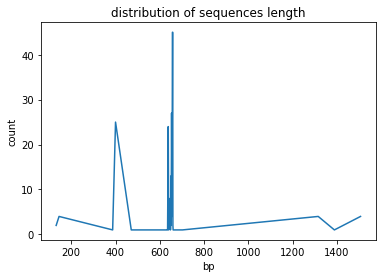

In [3]:
import matplotlib.pyplot as plt

x = sorted(set(l))
y = [l.count(x) for x in x]
plt.plot(x, y)
plt.title('distribution of sequences length')
plt.xlabel('bp')
plt.ylabel('count')
plt.show()
plt.close()

In [4]:
gc_df

,start index,gc-contents
0,62.0,41.339869
1,0.0,37.925170
2,0.0,43.000000
3,0.0,43.000000
4,0.0,43.000000
...,...,...
236,18.0,45.915033
237,18.0,45.751634
238,18.0,45.751634
239,0.0,40.151515


### 기존 데이터 슬라이싱 후 3-mer 적용

In [3]:
import pandas as pd
import numpy as np

file = SeqIO.parse('all_mammalia_coi.fasta', 'fasta')

k = 3
dict = {}
df = pd.DataFrame()

#[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

#[220508_1735]CREATED k = 3인 kmer의 모든 경우의 수를 사전형에 미리 저장
def init(datatype):
    for i in range(4):
        for j in range(4):
            for k in range(4):
                datatype[list(base_dict.keys())[i] + list(base_dict.keys())[j] + list(base_dict.keys())[k]] = 0
    #[220509_1517]CREATED k-means는 unsupervised이지만, 여기서는 표본의 타겟을 ncbi에서부터 추출가능하므로 타겟 피처 생성
    datatype['GC-contents'] = 0
    datatype['target'] = 0
    
init(df)

for i, record in enumerate(file):
    init(dict)
    record.seq = record.seq[int(gc_df.loc[i, 'start index']): int(gc_df.loc[i, 'start index']) + k_gc]
    #[220805_1023]CREATED 최대 GC 값 범위로 기존 데이터 슬라이싱
    dict['GC-contents'] = gc_df.loc[i, 'gc-contents']
    #[220805_1025]CREATED 최대 GC 값 저장
    dict['target'] = getGenbank(record.id).organism
    
    index = 0
    
    if(len(record.seq) >= k):
        while(index + k <= len(record.seq)):
            mer = record.seq[index:index + k]
            for p in range(k):
                mer = mer.replace(mer[p], base_dict.get(mer[p]))
            dict[mer] += 1
            index += 1
    df.loc[i] = dict

In [4]:
#[220811_1437]NOTED 9종으로 잘 크롤링되었음을 확인
df['target'].unique()

array(['Mus musculus', 'Canis lupus', 'Panthera tigris',
       'Ursus thibetanus', 'Tamias sibiricus', 'Petrogale brachyotis',
       'Thylogale thetis', 'Hystrix cristata', 'Phascolarctos cinereus'],
      dtype=object)

In [5]:
#[220509_1621]CREATED 레이블 인코딩으로 종 이름 -> 고유 숫자
from sklearn.preprocessing import LabelEncoder

a = df['target']
encoder = LabelEncoder()
labels = encoder.fit_transform(a)
#[220509_1622]NOTED* 종의 총 개수 = 19인 것을 알 수 있으므로 KMeans의 파라미터인 n_clusters를 14 -> 19로 수정
#[220513_1830]NOTED 종: 101개
#[220519_1745]NOTED 종: 9개
print(labels)

df['target'] = labels
df.head()

[2 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 8 2 2 0 0 0 0 0 0
 0 3 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 8 8 8 8 8 8 4 4 4 7 2 2 2
 2 2 2 2 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 2 3 8 2 2 2 2 2 2 2 2 2
 3 3 3 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 6 0 3 0 0 0 0 0
 1 2 2 6 0 0 0 0 5 5 1 1 1 1 1 1 8 8 8 8 8 8 8 8 8 8 8 8 2 3 2 2 2 2 0 0 0
 0 0 8 8 8 8 8 8 8 8 8 8 8 8 0 0 0 2 2]


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,7,3,14,20,6,12,15,10,11,1,...,11,3,10,10,16,7,9,24,41.339869,2
1,9,4,5,13,5,11,10,8,10,4,...,11,8,9,11,22,9,21,28,37.925170,0
2,8,2,3,8,2,4,6,3,7,6,...,11,2,6,5,8,9,9,12,43.000000,3
3,8,2,3,8,2,4,6,3,7,6,...,11,2,6,5,8,9,9,12,43.000000,3
4,8,2,3,8,2,4,6,3,7,6,...,11,2,6,5,8,9,9,12,43.000000,3


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
#[220805_1714]NOTED* GC함량을 정규화
scaler.fit(df['GC-contents'].array.reshape(-1, 1))
gc_scaled = scaler.transform(df['GC-contents'].array.reshape(-1, 1))
df['GC-contents'] = gc_scaled

In [7]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,7,3,14,20,6,12,15,10,11,1,...,11,3,10,10,16,7,9,24,0.604768,2
1,9,4,5,13,5,11,10,8,10,4,...,11,8,9,11,22,9,21,28,0.361840,0
2,8,2,3,8,2,4,6,3,7,6,...,11,2,6,5,8,9,9,12,0.722873,3
3,8,2,3,8,2,4,6,3,7,6,...,11,2,6,5,8,9,9,12,0.722873,3
4,8,2,3,8,2,4,6,3,7,6,...,11,2,6,5,8,9,9,12,0.722873,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,5,1,11,19,3,9,10,7,11,2,...,10,3,14,15,13,7,12,18,0.930253,0
237,6,1,12,19,2,9,10,7,11,2,...,10,3,14,15,13,7,12,18,0.918629,0
238,6,1,12,19,2,9,10,7,11,2,...,10,3,14,15,13,7,12,18,0.918629,0
239,1,2,3,5,2,1,3,2,1,0,...,4,4,0,3,3,1,4,2,0.520226,2


In [8]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED target수 <= cluster수일 때의 비지도학습에서의 정확도 계산 함수 생성

### PCA 차원축소 사용했을 때

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2).fit_transform(df.loc[:,:'GC-contents'])

df['pca_x'] = pca[:, 0]
df['pca_y'] = pca[:, 1]
df.head()

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target,pca_x,pca_y
0,7,3,14,20,6,12,15,10,11,1,...,10,10,16,7,9,24,0.604768,2,-12.333172,-6.314843
1,9,4,5,13,5,11,10,8,10,4,...,9,11,22,9,21,28,0.361840,0,6.156173,-4.948375
2,8,2,3,8,2,4,6,3,7,6,...,6,5,8,9,9,12,0.722873,3,34.636001,-12.812655
3,8,2,3,8,2,4,6,3,7,6,...,6,5,8,9,9,12,0.722873,3,34.636001,-12.812655
4,8,2,3,8,2,4,6,3,7,6,...,6,5,8,9,9,12,0.722873,3,34.636001,-12.812655


In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

df['sil_sam'] = silhouette_samples(df[['pca_x', 'pca_y']], df['target'])
#[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
sil_tot = silhouette_score(df[['pca_x', 'pca_y']], df['target'])
#[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
sil_clu = df.groupby('target')['sil_sam'].mean()
score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
#print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
#print('score: {0:.3f}'.format(score_k))
#[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
#print('---------------')
print(sil_tot / score_k)

1.8492334492540752


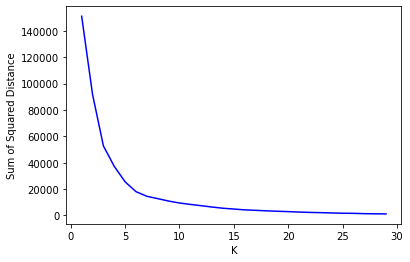

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 1000)
    km.fit(df.loc[:,:'GC-contents'])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=500)
    kmeans.fit(df.loc[:,:'GC-contents'])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df.loc[:,:'GC-contents'], df['cluster'])
    sil_tot = silhouette_score(df.loc[:,:'GC-contents'], df['cluster'])
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
#[220801_1637]CREATED 전체 실루엣 계수 평균이 높으면서 군집 별 실루엣 계수와 크게 차이나지 않는 k 값은 9이다.

전체 실루엣 계수 평균: 0.550
군집 별 실루엣 계수 평균: 
cluster
0    0.522621
1    0.732302
Name: sil_sam, dtype: float64
score: 0.105
---------------
전체 실루엣 계수 평균: 0.557
군집 별 실루엣 계수 평균: 
cluster
0    0.566766
1    0.680375
2    0.462194
Name: sil_sam, dtype: float64
score: 0.076
---------------
전체 실루엣 계수 평균: 0.596
군집 별 실루엣 계수 평균: 
cluster
0    0.372281
1    0.719427
2    0.680146
3    0.451324
Name: sil_sam, dtype: float64
score: 0.144
---------------
전체 실루엣 계수 평균: 0.675
군집 별 실루엣 계수 평균: 
cluster
0    0.392404
1    0.719368
2    0.671057
3    0.892047
4    0.609274
Name: sil_sam, dtype: float64
score: 0.123
---------------
전체 실루엣 계수 평균: 0.697
군집 별 실루엣 계수 평균: 
cluster
0    0.392404
1    0.609274
2    0.719368
3    0.849561
4    0.892047
5    0.779508
Name: sil_sam, dtype: float64
score: 0.141
---------------
전체 실루엣 계수 평균: 0.719
군집 별 실루엣 계수 평균: 
cluster
0    0.625503
1    0.849795
2    0.708842
3    0.891776
4    0.641492
5    0.779508
6    0.389512
Name: sil_sam, dtype: float64
score: 0.125
--------------

In [11]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED target수 <= cluster수일 때의 비지도학습에서의 정확도 계산 함수 생성

In [43]:
km = KMeans(n_clusters = 7, max_iter = 1000)
km.fit(df.loc[:,:'GC-contents'])
df['cluster'] = km.labels_
cal_accuracy(df['target'], df['cluster'])

0.9580802968960865

In [44]:
ct = pd.crosstab(df['target'], df['cluster'])
ct

cluster,0,1,2,3,4,5,6
target,,,,,,,
0,25,0,0,0,0,1,0
1,0,0,0,0,0,0,7
2,0,111,1,0,2,0,0
3,1,0,26,0,4,0,1
4,0,0,0,0,0,0,3
5,0,0,0,0,0,0,2
6,0,0,0,0,0,21,3
7,0,0,0,0,0,0,1
8,0,0,0,32,0,0,0


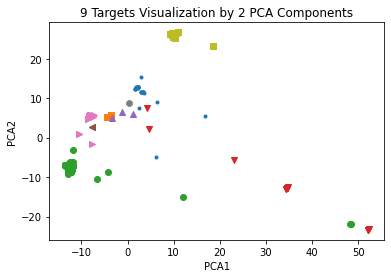

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Targets Visualization by 2 PCA Components')
plt.show()

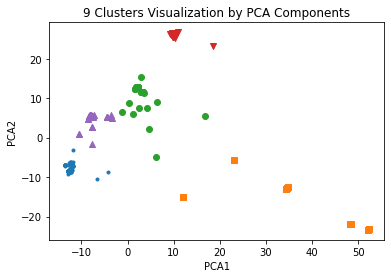

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Clusters Visualization by PCA Components')
plt.show()

In [ ]:
km2 = KMeans(n_clusters = 6, max_iter = 1000)
km2.fit(df[['tsne_x', 'tsne_y']])
cal_accuracy(df['target'], km2.labels_)

0.9419984255510572

### LDA 차원축소 사용했을 때

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components = 2)
lda.fit(df.loc[:, :'GC-contents'], df['target'])
ma_lda = lda.transform(df.loc[:, :'GC-contents'])
print(ma_lda.shape)

df['lda_x'] = ma_lda[:, 0]
df['lda_y'] = ma_lda[:, 1]
df.head()

(241, 2)


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TTG,TTC,TTT,GC-contents,target,pca_x,pca_y,sil_sam,lda_x,lda_y
0,7,3,14,20,6,12,15,10,11,1,...,7,9,24,0.604768,2,-12.333172,-6.314843,0.732259,149.163855,-40.479120
1,9,4,5,13,5,11,10,8,10,4,...,9,21,28,0.361840,0,6.156173,-4.948375,-0.233573,101.582326,192.381216
2,8,2,3,8,2,4,6,3,7,6,...,9,9,12,0.722873,3,34.636001,-12.812655,0.863316,-140.289860,105.257189
3,8,2,3,8,2,4,6,3,7,6,...,9,9,12,0.722873,3,34.636001,-12.812655,0.863316,-140.289860,105.257189
4,8,2,3,8,2,4,6,3,7,6,...,9,9,12,0.722873,3,34.636001,-12.812655,0.863316,-140.289860,105.257189


In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

df['sil_sam'] = silhouette_samples(df[['lda_x', 'lda_y']], df['target'])
#[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
sil_tot = silhouette_score(df[['lda_x', 'lda_y']], df['target'])
#[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
sil_clu = df.groupby('target')['sil_sam'].mean()
score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
#print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
#print('score: {0:.3f}'.format(score_k))
#[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
#print('---------------')
print(sil_tot / score_k)

8.565606105340503


In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average = 'macro')
    recall = recall_score(y_test, pred, average = 'macro')
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.2f}, 정밀도: {1:.2f}, 재현율: {2:.2f}'.format(accuracy, precision, recall))
    
    
svm_2 = SVC(kernel = 'linear') 
#[220715_1739]NOTED 모델 생성

X = df[['lda_x', 'lda_y']]
y = df['target']

scaler = StandardScaler()
new_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.2)
#[220715_1740]NOTED 학습 데이터와 테스트 데이어셋으로 무작위 분리한 뒤 정규화

parameters = {'C':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'gamma':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
#[220715_1741]NOTED 파라미터 후보 설정

grid_svm = GridSearchCV(svm_2, param_grid = parameters, cv = 5)
grid_svm.fit(X_train, y_train)  
#[220711_1658]NOTED 검증 데이터셋 + 학습 데이터셋 = 원래 학습 데이터셋

print(grid_svm.best_params_)
print(grid_svm.best_score_)
best_pred = grid_svm.best_estimator_.predict(X_test)
get_clf_eval(y_test, best_pred)

/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'C': 1, 'gamma': 1}
0.9947368421052631
오차 행렬
[[ 3  0  0  0  0  0]
 [ 0  1  0  0  0  0]
 [ 0  0 27  0  0  0]
 [ 0  0  0  7  0  0]
 [ 0  0  0  0  4  0]
 [ 0  0  0  0  0  7]]
정확도: 1.00, 정밀도: 1.00, 재현율: 1.00


### t-sne 차원축소 사용했을 때

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 30).fit_transform(df.loc[:,:'GC-contents'])

df['tsne_x'] = tsne[:, 0]
df['tsne_y'] = tsne[:, 1]
df.head()

/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TTT,GC-contents,target,pca_x,pca_y,sil_sam,lda_x,lda_y,tsne_x,tsne_y
0,7,3,14,20,6,12,15,10,11,1,...,24,0.604768,2,-12.333172,-6.314843,0.995115,149.163855,-40.479120,-1.773434,3.340011
1,9,4,5,13,5,11,10,8,10,4,...,28,0.361840,0,6.156173,-4.948375,0.990698,101.582326,192.381216,-9.720110,-1.194692
2,8,2,3,8,2,4,6,3,7,6,...,12,0.722873,3,34.636001,-12.812655,0.997109,-140.289860,105.257189,-3.353387,-21.521017
3,8,2,3,8,2,4,6,3,7,6,...,12,0.722873,3,34.636001,-12.812655,0.997109,-140.289860,105.257189,-4.432548,-21.377718
4,8,2,3,8,2,4,6,3,7,6,...,12,0.722873,3,34.636001,-12.812655,0.997109,-140.289860,105.257189,-3.581704,-21.864040


In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

df['sil_sam'] = silhouette_samples(df[['tsne_x', 'tsne_y']], df['target'])
#[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
sil_tot = silhouette_score(df[['tsne_x', 'tsne_y']], df['target'])
#[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
sil_clu = df.groupby('target')['sil_sam'].mean()
score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
#print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
#print('score: {0:.3f}'.format(score_k))
#[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
#print('---------------')
print(sil_tot / score_k)

0.6806314454302718


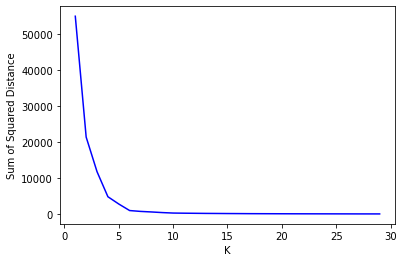

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 1000)
    km.fit(df[['tsne_x', 'tsne_y']])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=500)
    kmeans.fit(df[['tsne_x', 'tsne_y']])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df[['tsne_x', 'tsne_y']], df['cluster'])
    sil_tot = silhouette_score(df[['tsne_x', 'tsne_y']], df['cluster'])
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
#[220801_1637]CREATED 전체 실루엣 계수 평균이 높으면서 군집 별 실루엣 계수와 크게 차이나지 않는 k 값은 9이다.

전체 실루엣 계수 평균: 0.569
군집 별 실루엣 계수 평균: 
cluster
0    0.543511
1    0.585122
Name: sil_sam, dtype: float32
score: 0.021
---------------
전체 실루엣 계수 평균: 0.597
군집 별 실루엣 계수 평균: 
cluster
0    0.772990
1    0.461897
2    0.600400
Name: sil_sam, dtype: float32
score: 0.105
---------------
전체 실루엣 계수 평균: 0.683
군집 별 실루엣 계수 평균: 
cluster
0    0.772990
1    0.609212
2    0.559127
3    0.948408
Name: sil_sam, dtype: float32
score: 0.138
---------------
전체 실루엣 계수 평균: 0.731
군집 별 실루엣 계수 평균: 
cluster
0    0.772990
1    0.903191
2    0.888979
3    0.945499
4    0.494234
Name: sil_sam, dtype: float32
score: 0.165
---------------
전체 실루엣 계수 평균: 0.794
군집 별 실루엣 계수 평균: 
cluster
0    0.888979
1    0.700388
2    0.945499
3    0.735400
4    0.895638
5    0.730459
Name: sil_sam, dtype: float32
score: 0.094
---------------
전체 실루엣 계수 평균: 0.729
군집 별 실루엣 계수 평균: 
cluster
0    0.688212
1    0.895638
2    0.945499
3    0.514358
4    0.725077
5    0.888979
6    0.514278
Name: sil_sam, dtype: float32
score: 0.145
--------------

In [22]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED target수 <= cluster수일 때의 비지도학습에서의 정확도 계산 함수 생성

In [23]:
km = KMeans(n_clusters = 6, max_iter = 1000)
km.fit(df[['tsne_x', 'tsne_y']])
df['cluster'] = km.labels_
cal_accuracy(df['target'], df['cluster'])

0.9419984255510572

In [24]:
ct = pd.crosstab(df['target'], df['cluster'])
ct

cluster,0,1,2,3,4,5
target,,,,,,
0,0,0,0,0,25,1
1,0,0,0,0,0,7
2,2,46,66,0,0,0
3,30,0,0,0,2,0
4,0,0,0,0,0,3
5,0,2,0,0,0,0
6,0,0,0,0,0,24
7,0,0,0,0,0,1
8,0,0,0,32,0,0


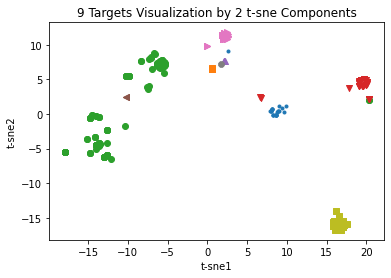

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'tsne_x'], y = df.loc[j, 'tsne_y'], marker = i)

plt.xlabel('t-sne1')
plt.ylabel('t-sne2')
plt.title('9 Targets Visualization by 2 t-sne Components')
plt.show()

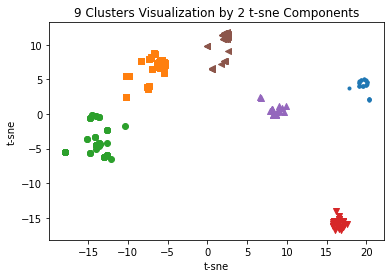

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'tsne_x'], y = df.loc[j, 'tsne_y'], marker = i)

plt.xlabel('t-sne')
plt.ylabel('t-sne')
plt.title('9 Clusters Visualization by 2 t-sne Components')
plt.show()

In [35]:
km2 = KMeans(n_clusters = 6, max_iter = 1000)
km2.fit(df[['tsne_x', 'tsne_y']])
cal_accuracy(df['target'], km2.labels_)

0.9419984255510572